**Chapter 12 – Custom Models and Training with TensorFlow**

_This notebook contains all the sample code in chapter 12._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/12_custom_models_and_training_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/12_custom_models_and_training_with_tensorflow.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Intro

Up until now, we’ve used only TensorFlow’s high-level API, tf.keras, but it
already got us pretty far: we built various neural network architectures,
including regression and classification nets, Wide & Deep nets, and selfnormalizing nets, using all sorts of techniques, such as Batch
Normalization, dropout, and learning rate schedules. In fact, 95% of the use
cases you will encounter will not require anything other than tf.keras (and
tf.data; see Chapter 13). But now it’s time to dive deeper into TensorFlow
and take a look at its lower-level Python API. This will be useful when you
need extra control to write custom loss functions, custom metrics, layers,
models, initializers, regularizers, weight constraints, and more. You may
even need to fully control the training loop itself, for example to apply
special transformations or constraints to the gradients (beyond just clipping
them) or to use multiple optimizers for different parts of the network. We
will cover all these cases in this chapter, and we will also look at how you
can boost your custom models and training algorithms using TensorFlow’s
automatic graph generation feature. But first, let’s take a quick tour of
TensorFlow.

# A quick tour of Tensorflow

As you know, TensorFlow is a powerful library for numerical computation,
particularly well suited and fine-tuned for large-scale Machine Learning
(but you could use it for anything else that requires heavy computations). It
was developed by the Google Brain team and it powers many of Google’s
large-scale services, such as Google Cloud Speech, Google Photos, and
Google Search. It was open sourced in November 2015, and it is now the
most popular Deep Learning library (in terms of citations in papers,
adoption in companies, stars on GitHub, etc.). Countless projects use
TensorFlow for all sorts of Machine Learning tasks, such as image
classification, natural language processing, recommender systems, and time
series forecasting.

So what does TensorFlow offer? Here’s a summary:
- Its core is very similar to NumPy, but with GPU support.
-It supports distributed computing (across multiple devices and
servers).
-It includes a kind of just-in-time (JIT) compiler that allows it to
optimize computations for speed and memory usage. It works by
extracting the computation graph from a Python function, then
optimizing it (e.g., by pruning unused nodes), and finally running it
efficiently (e.g., by automatically running independent operations
in parallel).
-Computation graphs can be exported to a portable format, so you
can train a TensorFlow model in one environment (e.g., using
Python on Linux) and run it in another (e.g., using Java on an
Android device).
-It implements autodiff (see Chapter 10 and Appendix D) and
provides some excellent optimizers, such as RMSProp and Nadam
(see Chapter 11), so you can easily minimize all sorts of loss
functions.

TensorFlow offers many more features built on top of these core features:
the most important is of course tf.keras, but it also has data loading and
preprocessing ops (tf.data, tf.io, etc.), image processing ops
1
(tf.image), signal processing ops (tf.signal), and more (see Figure 12-1
for an overview of TensorFlow’s Python API).

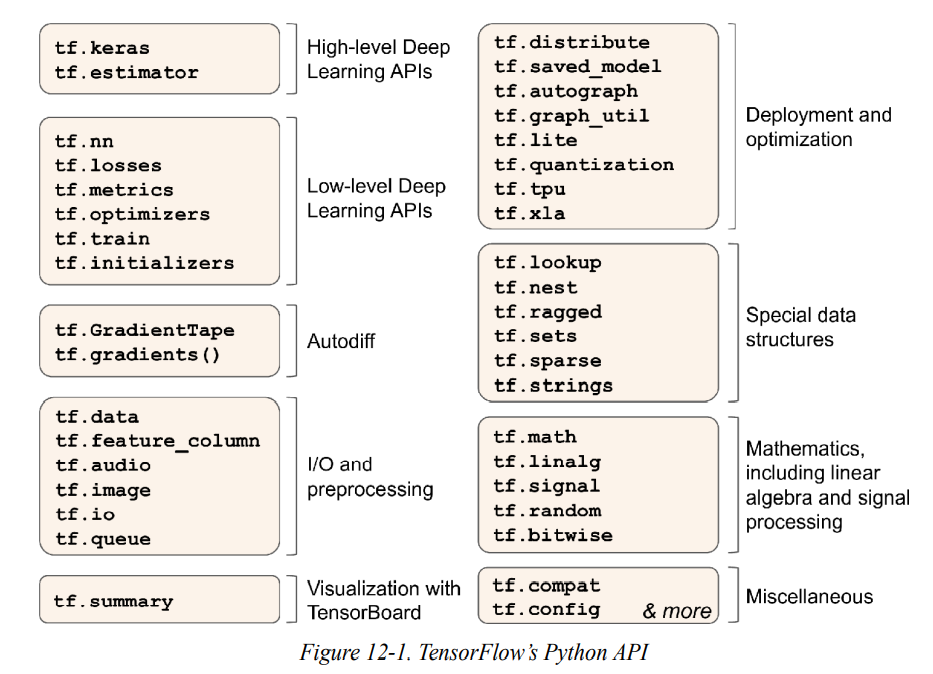

At the lowest level, each TensorFlow operation (op for short) is
implemented using highly efficient C++ code. Many operations have
multiple implementations called kernels: each kernel is dedicated to a
specific device type, such as CPUs, GPUs, or even TPUs (tensor processing
units). As you may know, GPUs can dramatically speed up computations by
splitting them into many smaller chunks and running them in parallel across
many GPU threads. TPUs are even faster: they are custom ASIC chips built
2
specifically for Deep Learning operations (we will discuss how to use
TensorFlow with GPUs or TPUs in Chapter 19).

TensorFlow’s architecture is shown in Figure 12-2. Most of the time your
code will use the high-level APIs (especially tf.keras and tf.data); but when
you need more flexibility, you will use the lower-level Python API,
handling tensors directly. Note that APIs for other languages are also
available. In any case, TensorFlow’s execution engine will take care of
running the operations efficiently, even across multiple devices and
machines if you tell it to.

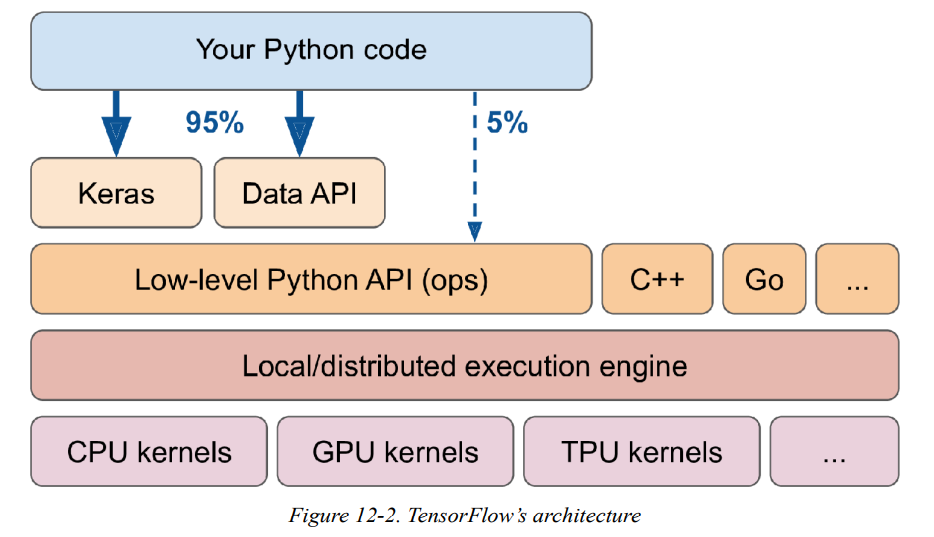

There’s more to TensorFlow than the library. TensorFlow is at the center of
an extensive ecosystem of libraries. First, there’s TensorBoard for
visualization (see Chapter 10). Next, there’s TensorFlow Extended (TFX),
3
which is a set of libraries built by Google to productionize TensorFlow
projects: it includes tools for data validation, preprocessing, model analysis,
and serving (with TF Serving; see Chapter 19). Google’s TensorFlow Hub
provides a way to easily download and reuse pretrained neural networks.
You can also get many neural network architectures, some of them
pretrained, in TensorFlow’s model garden. Check out the TensorFlow
Resources and https://github.com/jtoy/awesome-tensorflow for more
TensorFlow-based projects. You will find hundreds of TensorFlow projects
on GitHub, so it is often easy to find existing code for whatever you are
trying to do.


Also check out https://paperswithcode.com/ 

# Using TensorFlow like NumPy

TensorFlow’s API revolves around tensors, which flow from operation to
operation—hence the name TensorFlow. A tensor is usually a
multidimensional array (exactly like a NumPy ndarray), but it can also
hold a scalar (a simple value, such as 42). These tensors will be important
when we create custom cost functions, custom metrics, custom layers, and
more, so let’s see how to create and manipulate them

## Tensors and operations

### Tensors

You can create a tensor with tf.constant(). For example, here is a tensor
representing a matrix with two rows and three columns of floats

In [ ]:
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [ ]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

Just like an ndarray, a tf.Tensor has a shape and a data type (dtype):

In [ ]:
t.shape

TensorShape([2, 3])

In [ ]:
t.dtype

tf.float32

### Indexing

Indexing works much like in NumPy:

In [ ]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [ ]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

### Ops

Most importantly, all sorts of tensor operations are available:


In [ ]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [ ]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [ ]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

Note that writing t + 10 is equivalent to calling tf.add(t, 10). Other operators like - and * are also supported. The @
operator was added in Python 3.5, for matrix multiplication: it is equivalent
to calling the tf.matmul() function.

You will find all the basic math operations you need (tf.add(),
tf.multiply(), tf.square(), tf.exp(), tf.sqrt(), etc.) and most
operations that you can find in NumPy (e.g., tf.reshape(),
tf.squeeze(), tf.tile()). Some functions have a different name than in
NumPy; for instance, tf.reduce_mean(), tf.reduce_sum(),
tf.reduce_max(), and tf.math.log() are the equivalent of np.mean(),
np.sum(), np.max() and np.log(). When the name differs, there is often a
good reason for it. For example, in TensorFlow you must write
tf.transpose(t); you cannot just write t.T like in NumPy. The reason is
that the tf.transpose() function does not do exactly the same thing as
NumPy’s T attribute: in TensorFlow, a new tensor is created with its own
copy of the transposed data, while in NumPy, t.T is just a transposed view
on the same data. Similarly, the tf.reduce_sum() operation is named this
way because its GPU kernel (i.e., GPU implementation) uses a reduce
algorithm that does not guarantee the order in which the elements are
added: because 32-bit floats have limited precision, the result may change
ever so slightly every time you call this operation. The same is true of
tf.reduce_mean() (but of course tf.reduce_max() is deterministic).

### Using `keras.backend`

Keras' low-level API

The Keras API has its own low-level API, located in keras.backend. It
includes functions like square(), exp(), and sqrt(). In tf.keras, these
functions generally just call the corresponding TensorFlow operations.
If you want to write code that will be portable to other Keras
implementations, you should use these Keras functions. However, they
only cover a subset of all functions available in TensorFlow, so in this
book we will use the TensorFlow operations directly. Here is as simple
example using keras.backend, which is commonly named K for short:


In [ ]:
from tensorflow import keras
K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

## Tensors and NumPy

Tensors play nice with NumPy: you can create a tensor from a NumPy
array, and vice versa. You can even apply TensorFlow operations to NumPy
arrays and NumPy operations to tensors:

### From/To NumPy

In [ ]:
a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [ ]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [ ]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [ ]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [ ]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

WARNING

Notice that NumPy uses 64-bit precision by default, while TensorFlow uses 32-bit. This
is because 32-bit precision is generally more than enough for neural networks, plus it
runs faster and uses less RAM. So when you create a tensor from a NumPy array, make
sure to set dtype=tf.float32

## Type Conversions

Type conversions can significantly hurt performance, and they can easily go
unnoticed when they are done automatically. To avoid this, TensorFlow
does not perform any type conversions automatically: it just raises an
exception if you try to execute an operation on tensors with incompatible
types. For example, you cannot add a float tensor and an integer tensor, and
you cannot even add a 32-bit float and a 64-bit float

In [ ]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [ ]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]


This may be a bit annoying at first, but remember that it’s for a good cause!
And of course you can use tf.cast() when you really need to convert
types:

In [ ]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

## Variables

The tf.Tensor values we’ve seen so far are immutable: you cannot modify
them. This means that we cannot use regular tensors to implement weights
in a neural network, since they need to be tweaked by backpropagation.
Plus, other parameters may also need to change over time (e.g., a
momentum optimizer keeps track of past gradients). What we need is a
tf.Variable

In [ ]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

A tf.Variable acts much like a tf.Tensor: you can perform the same
operations with it, it plays nicely with NumPy as well, and it is just as picky
with types. But it can also be modified in place using the assign() method
(or assign_add() or assign_sub(), which increment or decrement the
variable by the given value). You can also modify individual cells (or
slices), by using the cell’s (or slice’s) assign() method (direct item
assignment will not work) or by using the scatter_update() or
scatter_nd_update() methods:

In [ ]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [ ]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [ ]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


In [ ]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [ ]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

NOTE

In practice you will rarely have to create variables manually, since Keras provides an
add_weight() method that will take care of it for you, as we will see. Moreover, model
parameters will generally be updated directly by the optimizers, so you will rarely need
to update variables manually.

## Other Data Structures

### Sparse tensors

Efficiently represent tensors containing mostly zeros. The tf.sparse
package contains operations for sparse tensors.

In [ ]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [ ]:
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [ ]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [ ]:
s2 = s * 2.0

In [ ]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [ ]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [ ]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [ ]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [ ]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

### Tensor Arrays

Are lists of tensors. They have a fixed size by default but can optionally
be made dynamic. All tensors they contain must have the same shape
and data type.

In [ ]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [ ]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [ ]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [ ]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>

In [ ]:
variance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>

### Ragged tensors

Represent static lists of lists of tensors, where every tensor has the same
shape and data type. The tf.ragged package contains operations for
ragged tensors.

In [ ]:
print(r[1])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)


In [ ]:
print(r[1:3])

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [ ]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
print(tf.concat([r, r2], axis=0))

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>


In [ ]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71], [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [ ]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [ ]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>

### Strings

Are regular tensors of type tf.string. These represent byte strings, not
Unicode strings, so if you create a string tensor using a Unicode string
(e.g., a regular Python 3 string like "café"), then it will get encoded to
UTF-8 automatically (e.g., b"caf\xc3\xa9"). Alternatively, you can
represent Unicode strings using tensors of type tf.int32, where each
item represents a Unicode code point (e.g., [99, 97, 102, 233]). The
tf.strings package (with an s) contains ops for byte strings and
Unicode strings (and to convert one into the other). It’s important to
note that a tf.string is atomic, meaning that its length does not appear
in the tensor’s shape. Once you convert it to a Unicode tensor (i.e., a
tensor of type tf.int32 holding Unicode code points), the length
appears in the shape.

In [ ]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [ ]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [ ]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [ ]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [ ]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### String arrays

In [ ]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [ ]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [ ]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

In [ ]:
print(r)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>


### Sets

Are represented as regular tensors (or sparse tensors). For example,
tf.constant([[1, 2], [3, 4]]) represents the two sets {1, 2} and
{3, 4}. More generally, each set is represented by a vector in the
tensor’s last axis. You can manipulate sets using operations from the
tf.sets package.

In [ ]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]], dtype=int32)>

In [ ]:
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [ ]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

### Queues

Store tensors across multiple steps. TensorFlow offers various kinds of
queues: simple First In, First Out (FIFO) queues (FIFOQueue), queues
that can prioritize some items (PriorityQueue), shuffle their items
(RandomShuffleQueue), and batch items of different shapes by padding
(PaddingFIFOQueue). These classes are all in the tf.queue package.

# Customizing Models and Training algorithms

## Custom loss function

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Suppose you want to train a regression model, but your training set is a bit
noisy. Of course, you start by trying to clean up your dataset by removing
or fixing the outliers, but that turns out to be insufficient; the dataset is still
noisy. Which loss function should you use? The mean squared error might
penalize large errors too much and cause your model to be imprecise. The
mean absolute error would not penalize outliers as much, but training might
take a while to converge, and the trained model might not be very precise.
This is probably a good time to use the Huber loss (introduced in
Chapter 10) instead of the good old MSE. The Huber loss is not currently
part of the official Keras API, but it is available in tf.keras (just use an
instance of the keras.losses.Huber class). But let’s pretend it’s not there:
implementing it is easy as pie! Just create a function that takes the labels
and predictions as arguments, and use TensorFlow operations to compute
every instance’s loss:


In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

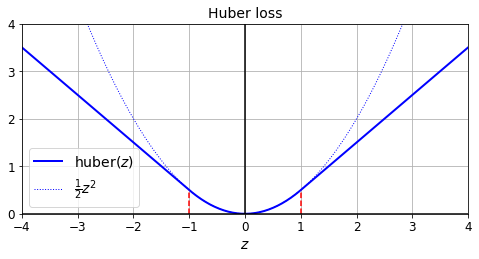

In [ ]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

WARNING

For better performance, you should use a vectorized implementation, as in this example.
Moreover, if you want to benefit from TensorFlow’s graph features, you should use only
TensorFlow operations.

In [ ]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

It is also preferable to return a tensor containing one loss per instance,
rather than returning the mean loss. This way, Keras can apply class
weights or sample weights when requested (see Chapter 10).
Now you can use this loss when you compile the Keras model, then train
your model

In [ ]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.0443 - mae: 1.4660 - val_loss: 0.2862 - val_mae: 0.5866
Epoch 2/2
363/363 [==============================] - 0s 737us/step - loss: 0.2379 - mae: 0.5407 - val_loss: 0.2382 - val_mae: 0.5281


And that’s it! For each batch during training, Keras will call the
huber_fn() function to compute the loss and use it to perform a Gradient
Descent step. Moreover, it will keep track of the total loss since the
beginning of the epoch, and it will display the mean loss.
But what happens to this custom loss when you save the model?

## Saving/Loading Models with Custom Objects

Saving a model containing a custom loss function works fine, as Keras
saves the name of the function. Whenever you load it, you’ll need to
provide a dictionary that maps the function name to the actual function.
More generally, when you load a model containing custom objects, you
need to map the names to the objects

In [ ]:
model.save("my_model_with_a_custom_loss.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 970us/step - loss: 0.2054 - mae: 0.4982 - val_loss: 0.2209 - val_mae: 0.5050
Epoch 2/2
363/363 [==============================] - 0s 769us/step - loss: 0.1999 - mae: 0.4900 - val_loss: 0.2127 - val_mae: 0.4986


With the current implementation, any error between –1 and 1 is considered
“small.” But what if you want a different threshold? One solution is to
create a function that creates a configured loss function:

In [ ]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2318 - mae: 0.4979 - val_loss: 0.2540 - val_mae: 0.4907
Epoch 2/2
363/363 [==============================] - 0s 749us/step - loss: 0.2309 - mae: 0.4960 - val_loss: 0.2372 - val_mae: 0.4879


In [ ]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

Unfortunately, when you save the model, the threshold will not be saved.
This means that you will have to specify the threshold value when loading
the model (note that the name to use is "huber_fn", which is the name of
the function you gave Keras, not the name of the function that created it):

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2147 - mae: 0.4800 - val_loss: 0.2133 - val_mae: 0.4654
Epoch 2/2
363/363 [==============================] - 0s 763us/step - loss: 0.2119 - mae: 0.4762 - val_loss: 0.1992 - val_mae: 0.4643


You can solve this by creating a subclass of the keras.losses.Loss class,
and then implementing its get_config() method:

In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

Let’s walk through this code:

- The constructor accepts **kwargs and passes them to the parent
constructor, which handles standard hyperparameters: the name of
the loss and the reduction algorithm to use to aggregate the
individual instance losses. By default, it is
"sum_over_batch_size", which means that the loss will be the
sum of the instance losses, weighted by the sample weights, if any,
and divided by the batch size (not by the sum of weights, so this is
not the weighted mean). Other possible values are "sum" and
None.

- The call() method takes the labels and predictions, computes all
the instance losses, and returns them.

- The get_config() method returns a dictionary mapping each
hyperparameter name to its value. It first calls the parent class’s
get_config() method, then adds the new hyperparameters to this
dictionary (note that the convenient {**x} syntax was added in
Python 3.5).

WARNING

The Keras API currently only specifies how to use subclassing to define layers, models,
callbacks, and regularizers. If you build other components (such as losses, metrics,
initializers, or constraints) using subclassing, they may not be portable to other Keras
implementations. It’s likely that the Keras API will be updated to specify subclassing for
all these components as well.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.3123 - mae: 1.3345 - val_loss: 0.3378 - val_mae: 0.5485
Epoch 2/2
363/363 [==============================] - 0s 760us/step - loss: 0.2659 - mae: 0.5270 - val_loss: 0.2660 - val_mae: 0.5089


In [ ]:
model.save("my_model_with_a_custom_loss_class.h5")

You can then use any instance of this class when you compile the model:

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 966us/step - loss: 0.2286 - mae: 0.4970 - val_loss: 0.2120 - val_mae: 0.4723
Epoch 2/2
363/363 [==============================] - 0s 757us/step - loss: 0.2216 - mae: 0.4904 - val_loss: 0.2045 - val_mae: 0.4725


In [ ]:
model.loss.threshold

2.0

When you save a model, Keras calls the loss instance’s get_config()
method and saves the config as JSON in the HDF5 file. When you load the
model, it calls the from_config() class method on the HuberLoss class:
this method is implemented by the base class (Loss) and creates an instance
of the class, passing **config to the constructor.
That’s it for losses! That wasn’t too hard, was it? Just as simple are custom
activation functions, initializers, regularizers, and constraints. Let’s look at
these now

## Other Custom Activation Functions, Initializers, Regularizers, and Constraints

Most Keras functionalities, such as losses, regularizers, constraints,
initializers, metrics, activation functions, layers, and even full models, can
be customized in very much the same way. Most of the time, you will just
need to write a simple function with the appropriate inputs and outputs.
Here are examples of a custom activation function (equivalent to
keras.activations.softplus() or tf.nn.softplus()), a custom
Glorot initializer (equivalent to keras.initializers.glorot_normal()),
a custom ℓ regularizer (equivalent to keras.regularizers.l1(0.01)),
and a custom constraint that ensures weights are all positive (equivalent to
keras.constraints.nonneg() or tf.nn.relu()):

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

As you can see, the arguments depend on the type of custom function.
These custom functions can then be used normally; for example:

In [ ]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.3829 - mae: 1.1635 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 0s 757us/step - loss: 0.6299 - mae: 0.5410 - val_loss: 1.4399 - val_mae: 0.5137


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

The activation function will be applied to the output of this Dense layer, and
its result will be passed on to the next layer. The layer’s weights will be
initialized using the value returned by the initializer. At each training step
the weights will be passed to the regularization function to compute the
regularization loss, which will be added to the main loss to get the final loss
used for training. Finally, the constraint function will be called after each
training step, and the layer’s weights will be replaced by the constrained
weights.

If a function has hyperparameters that need to be saved along with the
model, then you will want to subclass the appropriate class, such as
keras.regularizers.Regularizer, keras.constraints.Constraint,
keras.initializers.Initializer, or keras.layers.Layer (for any
layer, including activation functions). Much like we did for the custom loss,
here is a simple class for ℓ regularization that saves its factor
hyperparameter (this time we do not need to call the parent constructor or
the get_config() method, as they are not defined by the parent class):

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

Note that you must implement the call() method for losses, layers
(including activation functions), and models, or the __call__() method for
regularizers, initializers, and constraints.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.3829 - mae: 1.1635 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 0s 757us/step - loss: 0.6299 - mae: 0.5410 - val_loss: 1.4399 - val_mae: 0.5137


In [ ]:
model.save("my_model_with_many_custom_parts.h5")

In [ ]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

## Custom Metrics

For metrics, things are a bit
different, as we will see now.


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

Losses and metrics are conceptually not the same thing: losses (e.g., cross
entropy) are used by Gradient Descent to train a model, so they must be
differentiable (at least where they are evaluated), and their gradients should
not be 0 everywhere. Plus, it’s OK if they are not easily interpretable by
humans. In contrast, metrics (e.g., accuracy) are used to evaluate a model:
they must be more easily interpretable, and they can be non-differentiable
or have 0 gradients everywhere.
That said, in most cases, defining a custom metric function is exactly the
same as defining a custom loss function. In fact, we could even use the
Huber loss function we created earlier as a metric; it would work just fine
(and persistence would also work the same way, in this case only saving the
name of the function, "huber_fn"):

In [ ]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 572us/step - loss: 3.5903 - huber_fn: 1.5558
Epoch 2/2
363/363 [==============================] - 0s 552us/step - loss: 0.8054 - huber_fn: 0.3095


**Note**: if you use the same function as the loss and a metric, you may be surprised to see different results. This is generally just due to floating point precision errors: even though the mathematical equations are equivalent, the operations are not run in the same order, which can lead to small differences. Moreover, when using sample weights, there's more than just precision errors:
* the loss since the start of the epoch is the mean of all batch losses seen so far. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

If you do the math, you will find that loss = metric * mean of sample weights (plus some floating point precision error).

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 598us/step - loss: 0.1245 - huber_fn: 0.2515
Epoch 2/2
363/363 [==============================] - 0s 558us/step - loss: 0.1216 - huber_fn: 0.2473


In [ ]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11749906837940216, 0.11906625573138947)

For each batch during training, Keras will compute this metric and keep
track of its mean since the beginning of the epoch. Most of the time, this is
exactly what you want. But not always! Consider a binary classifier’s
precision, for example. As we saw in Chapter 3, precision is the number of
true positives divided by the number of positive predictions (including both
true positives and false positives). Suppose the model made five positive
predictions in the first batch, four of which were correct: that’s 80%
precision. Then suppose the model made three positive predictions in the
second batch, but they were all incorrect: that’s 0% precision for the second
batch. If you just compute the mean of these two precisions, you get 40%.
6
But wait a second—that’s not the model’s precision over these two batches!
Indeed, there were a total of four true positives (4 + 0) out of eight positive
predictions (5 + 3), so the overall precision is 50%, not 40%. What we need
is an object that can keep track of the number of true positives and the
number of false positives and that can compute their ratio when requested.
This is precisely what the keras.metrics.Precision class does:

In [ ]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In this example, we created a Precision object, then we used it like a
function, passing it the labels and predictions for the first batch, then for the
second batch (note that we could also have passed sample weights). We
used the same number of true and false positives as in the example we just
discussed. After the first batch, it returns a precision of 80%; then after the
second batch, it returns 50% (which is the overall precision so far, not the
second batch’s precision). This is called a streaming metric (or stateful
metric), as it is gradually updated, batch after batch.
At any point, we can call the result() method to get the current value of
the metric. We can also look at its variables (tracking the number of true
and false positives) by using the variables attribute, and we can reset
these variables using the reset_states() method:

In [ ]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [ ]:
precision.reset_states()

### Streaming metric

If you need to create such a streaming metric, create a subclass of the
keras.metrics.Metric class. Here is a simple example that keeps track of
the total Huber loss and the number of instances seen so far. When asked
for the result, it returns the ratio, which is simply the mean Huber loss:

Creating a streaming metric:

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

Let’s walk through this code:

- The constructor uses the add_weight() method to create the
variables needed to keep track of the metric’s state over multiple
batches—in this case, the sum of all Huber losses (total) and the
number of instances seen so far (count). You could just create
variables manually if you preferred. Keras tracks any tf.Variable
that is set as an attribute (and more generally, any “trackable”
object, such as layers or models).
- The update_state() method is called when you use an instance
of this class as a function (as we did with the Precision object). It
updates the variables, given the labels and predictions for one
batch (and sample weights, but in this case we ignore them).
- The result() method computes and returns the final result, in this
case the mean Huber metric over all instances. When you use the
metric as a function, the update_state() method gets called first,
then the result() method is called, and its output is returned.

- We also implement the get_config() method to ensure the
threshold gets saved along with the model.
- The default implementation of the reset_states() method resets
all variables to 0.0 (but you can override it if needed).

Keras will take care of variable persistence seamlessly; no action is required.

In [ ]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]])) 

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [ ]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [ ]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [ ]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the `HuberMetric` class works well:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 592us/step - loss: 1.5182 - huber_metric: 1.5182
Epoch 2/2
363/363 [==============================] - 0s 538us/step - loss: 0.2909 - huber_metric: 0.2909


In [ ]:
model.save("my_model_with_a_custom_metric.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 545us/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 0s 524us/step - loss: 0.2278 - huber_metric: 0.2278


**Warning**: In TF 2.2, tf.keras adds an extra first metric in `model.metrics` at position 0 (see [TF issue #38150](https://github.com/tensorflow/tensorflow/issues/38150)). This forces us to use `model.metrics[-1]` rather than `model.metrics[0]` to access the `HuberMetric`.

In [ ]:
model.metrics[-1].threshold

2.0

Looks like it works fine! More simply, we could have created the class like this:

In [ ]:
class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}        

This class handles shapes better, and it also supports sample weights.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])

In [ ]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 627us/step - loss: 0.7800 - HuberMetric: 1.5672
Epoch 2/2
363/363 [==============================] - 0s 607us/step - loss: 0.1462 - HuberMetric: 0.2939


In [ ]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.44554394483566284, 0.44554404180100277)

In [ ]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

In [ ]:
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 0s 578us/step - loss: 0.2377 - HuberMetric: 0.2377
Epoch 2/2
363/363 [==============================] - 0s 559us/step - loss: 0.2279 - HuberMetric: 0.2279


In [ ]:
model.metrics[-1].threshold

2.0

When you define a metric using a simple function, Keras automatically
calls it for each batch, and it keeps track of the mean during each epoch,
just like we did manually. So the only benefit of our HuberMetric class is
that the threshold will be saved. But of course, some metrics, like
precision, cannot simply be averaged over batches: in those cases, there’s
no other option than to implement a streaming metric.
Now that we have built a streaming metric, building a custom layer will
seem like a walk in the park!

## Custom Layers

You may occasionally want to build an architecture that contains an exotic
layer for which TensorFlow does not provide a default implementation. In
this case, you will need to create a custom layer. Or you may simply want to
build a very repetitive architecture, containing identical blocks of layers
repeated many times, and it would be convenient to treat each block of
layers as a single layer. For example, if the model is a sequence of layers A,
B, C, A, B, C, A, B, C, then you might want to define a custom layer D
containing layers A, B, C, so your model would then simply be D, D, D.
Let’s see how to build custom layers.

First, some layers have no weights, such as keras.layers.Flatten or
keras.layers.ReLU. If you want to create a custom layer without any
weights, the simplest option is to write a function and wrap it in a
keras.layers.Lambda layer. For example, the following layer will apply
the exponential function to its inputs:

In [ ]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [ ]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

This custom layer can then be used like any other layer, using the
Sequential API, the Functional API, or the Subclassing API. You can also
use it as an activation function (or you could use activation=tf.exp,
activation=keras.activations.exponential, or simply
activation="exponential"). The exponential layer is sometimes used in
the output layer of a regression model when the values to predict have very
different scales (e.g., 0.001, 10., 1,000.).


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 0s 828us/step - loss: 2.1275 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 0s 645us/step - loss: 0.4750 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 0s 656us/step - loss: 0.4230 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 0s 657us/step - loss: 0.3905 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 420us/step - loss: 0.3586


0.3586340546607971

As you’ve probably guessed by now, to build a custom stateful layer (i.e., a
layer with weights), you need to create a subclass of the
keras.layers.Layer class. For example, the following class implements a
simplified version of the Dense layer:

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

Let’s walk through this code:

- The constructor takes all the hyperparameters as arguments (in this
example, units and activation), and importantly it also takes a **kwargs argument. It calls the parent constructor, passing it the
kwargs: this takes care of standard arguments such as
input_shape, trainable, and name. Then it saves the
hyperparameters as attributes, converting the activation
argument to the appropriate activation function using the
keras.activations.get() function (it accepts functions,
standard strings like "relu" or "selu", or simply None).
- The build() method’s role is to create the layer’s variables by
calling the add_weight() method for each weight. The build()
method is called the first time the layer is used. At that point, Keras
will know the shape of this layer’s inputs, and it will pass it to the
build() method, which is often necessary to create some of the
weights. For example, we need to know the number of neurons in
the previous layer in order to create the connection weights matrix
(i.e., the "kernel"): this corresponds to the size of the last
dimension of the inputs. At the end of the build() method (and
only at the end), you must call the parent’s build() method: this
tells Keras that the layer is built (it just sets self.built=True).
- The call() method performs the desired operations. In this case,
we compute the matrix multiplication of the inputs X and the
layer’s kernel, we add the bias vector, and we apply the activation
function to the result, and this gives us the output of the layer.
- The compute_output_shape() method simply returns the shape
of this layer’s outputs. In this case, it is the same shape as the
inputs, except the last dimension is replaced with the number of
neurons in the layer. Note that in tf.keras, shapes are instances of
the tf.TensorShape class, which you can convert to Python lists
using as_list().
- The get_config() method is just like in the previous custom
classes. Note that we save the activation function’s full
configuration by calling keras.activations.serialize().

You can now use a MyDense layer just like any other layer!

NOTE

You can generally omit the compute_output_shape() method, as tf.keras
automatically infers the output shape, except when the layer is dynamic (as we will see
shortly). In other Keras implementations, this method is either required or its default
implementation assumes the output shape is the same as the input shape.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 898us/step - loss: 4.1268 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 419us/step - loss: 0.5474


0.5473727583885193

In [ ]:
model.save("my_model_with_a_custom_layer.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

To create a layer with multiple inputs (e.g., Concatenate), the argument to
the call() method should be a tuple containing all the inputs, and similarly
the argument to the compute_output_shape() method should be a tuple
containing each input’s batch shape. To create a layer with multiple outputs,
the call() method should return the list of outputs, and
compute_output_shape() should return the list of batch output shapes
(one per output). For example, the following toy layer takes two inputs and
returns three outputs:

In [ ]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

This layer may now be used like any other layer, but of course only using
the Functional and Subclassing APIs, not the Sequential API (which only
accepts layers with one input and one output).

Our custom layer can be called using the functional API like this:

In [ ]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


Note that the `call()` method receives symbolic inputs, whose shape is only partially specified (at this stage, we don't know the batch size, which is why the first dimension is `None`):

We can also pass actual data to the custom layer. To test this, let's split each dataset's inputs into two parts, with four features each:

In [ ]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# Printing the splitted data shapes
X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

Now notice that the shapes are fully specified:

In [ ]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


Let's build a more complete model using the functional API (this is just a toy example, don't expect awesome performance):

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

X1.shape:  (None, 4)  X2.shape:  (None, 4)


In [ ]:
model.compile(loss='mse', optimizer='nadam')

In [ ]:
model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/2
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 1s 1ms/step - loss: 3.5973 - val_loss: 1.3630
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 1.0132 - val_loss: 0.9773


If your layer needs to have a different behavior during training and during
testing (e.g., if it uses Dropout or BatchNormalization layers), then you
must add a training argument to the call() method and use this
argument to decide what to do. For example, let’s create a layer that adds
Gaussian noise during training (for regularization) but does nothing during
testing (Keras has a layer that does the same thing,
keras.layers.GaussianNoise)

In [ ]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

Here's a simple model that uses this custom layer:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 892us/step - loss: 3.7869 - val_loss: 7.6082
Epoch 2/2
162/162 [==============================] - 0s 416us/step - loss: 0.7560


0.7559615969657898

## Custom Models

We already looked at creating custom model classes in Chapter 10, when
we discussed the Subclassing API. It’s straightforward: subclass the
keras.Model class, create layers and variables in the constructor, and
implement the call() method to do whatever you want the model to do.
Suppose you want to build the model represented in Figure 12-3.

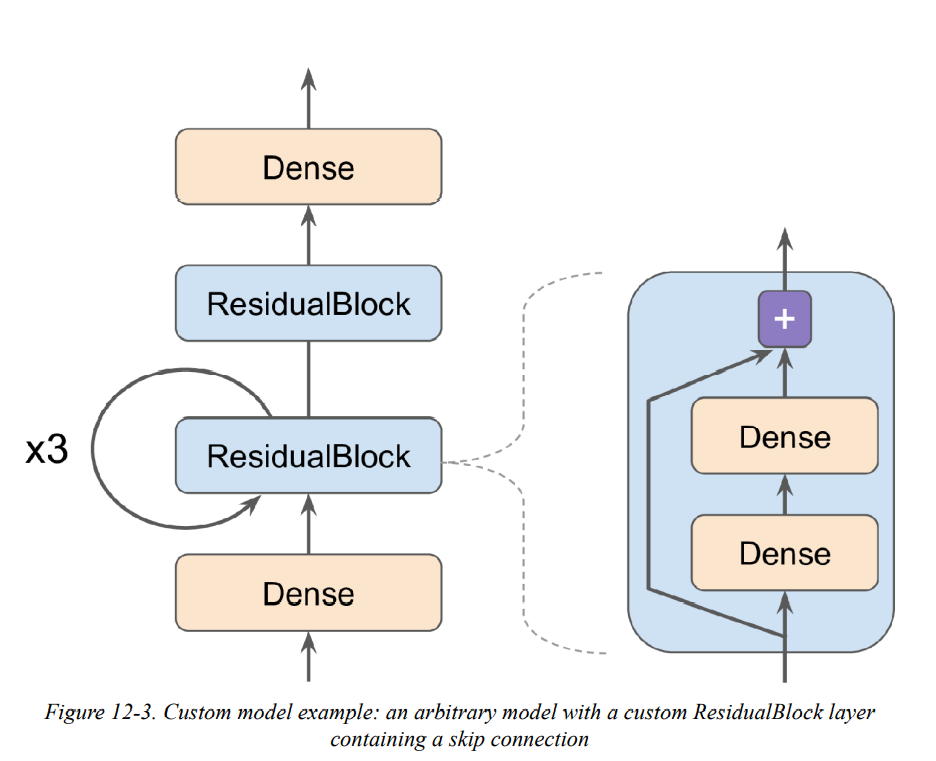

The inputs go through a first dense layer, then through a residual block
composed of two dense layers and an addition operation (as we will see in
Chapter 14, a residual block adds its inputs to its outputs), then through this
same residual block three more times, then through a second residual block,
and the final result goes through a dense output layer. Note that this model
does not make much sense; it’s just an example to illustrate the fact that you
can easily build any kind of model you want, even one that contains loops
and skip connections. To implement this model, it is best to first create a
ResidualBlock layer, since we are going to create a couple of identical
blocks (and we might want to reuse it in another model):

In [ ]:
X_new_scaled = X_test_scaled

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

This layer is a bit special since it contains other layers. This is handled
transparently by Keras: it automatically detects that the hidden attribute
contains trackable objects (layers in this case), so their variables are
automatically added to this layer’s list of variables. The rest of this class is
self-explanatory. Next, let’s use the Subclassing API to define the model
itself:

In [ ]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

We create the layers in the constructor and use them in the call() method.
This model can then be used like any other model (compile it, fit it,
evaluate it, and use it to make predictions). If you also want to be able to
save the model using the save() method and load it using the
keras.models.load_model() function, you must implement the
get_config() method (as we did earlier) in both the ResidualBlock class
and the ResidualRegressor class. Alternatively, you can save and load the
weights using the save_weights() and load_weights() methods.
The Model class is a subclass of the Layer class, so models can be defined
and used exactly like layers. But a model has some extra functionalities,
including of course its compile(), fit(), evaluate(), and predict()
methods (and a few variants), plus the get_layers() method (which can
return any of the model’s layers by name or by index) and the save()
method (and support for keras.models.load_model() and
keras.models.clone_model()).


In [1]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

NameError: ignored

In [ ]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 1s 837us/step - loss: 22.7478
Epoch 2/5
363/363 [==============================] - 0s 739us/step - loss: 1.2735
Epoch 3/5
363/363 [==============================] - 0s 737us/step - loss: 0.9792
Epoch 4/5
363/363 [==============================] - 0s 740us/step - loss: 0.5905
Epoch 5/5
162/162 [==============================] - 0s 526us/step - loss: 0.6513


In [ ]:
model.save("my_custom_model.ckpt")

INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


INFO:tensorflow:Assets written to: my_custom_model.ckpt/assets


In [ ]:
model = keras.models.load_model("my_custom_model.ckpt")

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 851us/step - loss: 0.9476
Epoch 2/5
363/363 [==============================] - 0s 736us/step - loss: 0.6998
Epoch 3/5
363/363 [==============================] - 0s 737us/step - loss: 0.4668
Epoch 4/5
363/363 [==============================] - 0s 758us/step - loss: 0.4818
Epoch 5/5
363/363 [==============================] - 0s 756us/step - loss: 0.4591


We could have defined the model using the sequential API instead:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 1s 709us/step - loss: 1.5508
Epoch 2/5
363/363 [==============================] - 0s 645us/step - loss: 0.5562
Epoch 3/5
363/363 [==============================] - 0s 625us/step - loss: 0.6406
Epoch 4/5
363/363 [==============================] - 0s 636us/step - loss: 0.3759
Epoch 5/5
162/162 [==============================] - 0s 463us/step - loss: 0.4852


TIP

If models provide more functionality than layers, why not just define every layer as a
model? Well, technically you could, but it is usually cleaner to distinguish the internal
components of your model (i.e., layers or reusable blocks of layers) from the model
itself (i.e., the object you will train). The former should subclass the Layer class, while
the latter should subclass the Model class.

With that, you can naturally and concisely build almost any model that you
find in a paper, using the Sequential API, the Functional API, the
Subclassing API, or even a mix of these. “Almost” any model? Yes, there
are still a few things that we need to look at: first, how to define losses or
metrics based on model internals, and second, how to build a custom
training loop

## Losses and Metrics Based on Model Internals

The custom losses and metrics we defined earlier were all based on the
labels and the predictions (and optionally sample weights). There will be
times when you want to define losses based on other parts of your model,
such as the weights or activations of its hidden layers. This may be useful
for regularization purposes or to monitor some internal aspect of your
model.

To define a custom loss based on model internals, compute it based on any
part of the model you want, then pass the result to the add_loss()
method.For example, let’s build a custom regression MLP model composed
of a stack of five hidden layers plus an output layer. This custom model will
also have an auxiliary output on top of the upper hidden layer. The loss
associated to this auxiliary output will be called the reconstruction loss (see
Chapter 17): it is the mean squared difference between the reconstruction
and the inputs. By adding this reconstruction loss to the main loss, we will
encourage the model to preserve as much information as possible through
the hidden layers—even information that is not directly useful for the
regression task itself. In practice, this loss sometimes improves
generalization (it is a regularization loss). Here is the code for this custom
model with a custom reconstruction loss:

**Note**: the following code has two differences with the code in the book:
1. It creates a `keras.metrics.Mean()` metric in the constructor and uses it in the `call()` method to track the mean reconstruction loss. Since we only want to do this during training, we add a `training` argument to the `call()` method, and if `training` is `True`, then we update `reconstruction_mean` and we call `self.add_metric()` to ensure it's displayed properly.
2. Due to an issue introduced in TF 2.2 ([#46858](https://github.com/tensorflow/tensorflow/issues/46858)), we must not call `super().build()` inside the `build()` method.

In [ ]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

Let’s go through this code:

- The constructor creates the DNN with five dense hidden layers and
one dense output layer.
- The build() method creates an extra dense layer which will be
used to reconstruct the inputs of the model. It must be created here
because its number of units must be equal to the number of inputs,
and this number is unknown before the build() method is called.
- The call() method processes the inputs through all five hidden
layers, then passes the result through the reconstruction layer,
which produces the reconstruction.
- Then the call() method computes the reconstruction loss (the
mean squared difference between the reconstruction and the
inputs), and adds it to the model’s list of losses using the
add_loss() method. Notice that we scale down the
reconstruction loss by multiplying it by 0.05 (this is a
hyperparameter you can tune). This ensures that the reconstruction
loss does not dominate the main loss.
- Finally, the call() method passes the output of the hidden layers
to the output layer and returns its output.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Similarly, you can add a custom metric based on model internals by
computing it in any way you want, as long as the result is the output of a
metric object. For example, you can create a keras.metrics.Mean object
in the constructor, then call it in the call() method, passing it the
recon_loss, and finally add it to the model by calling the model’s
add_metric() method. This way, when you train the model, Keras will
display both the mean loss over each epoch (the loss is the sum of the main
loss plus 0.05 times the reconstruction loss) and the mean reconstruction
error over each epoch. Both will go down during training:

In [ ]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 1s 810us/step - loss: 1.6313 - reconstruction_error: 1.0474
Epoch 2/2
363/363 [==============================] - 0s 683us/step - loss: 0.4536 - reconstruction_error: 0.4022


In over 99% of cases, everything we have discussed so far will be sufficient
to implement whatever model you want to build, even with complex
architectures, losses, and metrics. However, in some rare cases you may
need to customize the training loop itself. Before we get there, we need to
look at how to compute gradients automatically in TensorFlow.

## Computing Gradients with Autodiff

To understand how to use autodiff (see Chapter 10 and Appendix D) to
compute gradients automatically, let’s consider a simple toy function:

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

If you know calculus, you can analytically find that the partial derivative of
this function with regard to w1 is 6 * w1 + 2 * w2. You can also find that
its partial derivative with regard to w2 is 2 * w1. For example, at the point
(w1, w2) = (5, 3), these partial derivatives are equal to 36 and 10,
respectively, so the gradient vector at this point is (36, 10). But if this were
a neural network, the function would be much more complex, typically with
tens of thousands of parameters, and finding the partial derivatives
analytically by hand would be an almost impossible task. One solution
could be to compute an approximation of each partial derivative by
measuring how much the function’s output changes when you tweak the
corresponding parameter:

In [ ]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [ ]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

Looks about right! This works rather well and is easy to implement, but it is
just an approximation, and importantly you need to call f() at least once
per parameter (not twice, since we could compute f(w1, w2) just once).
Needing to call f() at least once per parameter makes this approach
intractable for large neural networks. So instead, we should use autodiff.
TensorFlow makes this pretty simple

We first define two variables w1 and w2, then we create a tf.GradientTape
context that will automatically record every operation that involves a
variable, and finally we ask this tape to compute the gradients of the result z
with regard to both variables [w1, w2]. Let’s take a look at the gradients
that TensorFlow computed

In [ ]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [ ]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

Perfect! Not only is the result accurate (the precision is only limited by the
floating-point errors), but the gradient() method only goes through the
recorded computations once (in reverse order), no matter how many
variables there are, so it is incredibly efficient. It’s like magic!

TIP

To save memory, only put the strict minimum inside the tf.GradientTape() block.
Alternatively, pause recording by creating a with tape.stop_recording() block
inside the tf.GradientTape() block.

The tape is automatically erased immediately after you call its gradient()
method, so you will get an exception if you try to call gradient() twice:


In [ ]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used tocompute one set of gradients (or jacobians)


If you need to call gradient() more than once, you must make the tape
persistent and delete it each time you are done with it to free resources:

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [ ]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

By default, the tape will only track operations involving variables, so if you
try to compute the gradient of z with regard to anything other than a
variable, the result will be None:

In [ ]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [ ]:
gradients

[None, None]

However, you can force the tape to watch any tensors you like, to record
every operation that involves them. You can then compute gradients with
regard to these tensors, as if they were variables:

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [ ]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

This can be useful in some cases, like if you want to implement a
regularization loss that penalizes activations that vary a lot when the inputs
vary little: the loss will be based on the gradient of the activations with
regard to the inputs. Since the inputs are not variables, you would need to
tell the tape to watch them.

Most of the time a gradient tape is used to compute the gradients of a single
value (usually the loss) with regard to a set of values (usually the model
12
parameters). This is where reverse-mode autodiff shines, as it just needs to
do one forward pass and one reverse pass to get all the gradients at once. If
you try to compute the gradients of a vector, for example a vector
containing multiple losses, then TensorFlow will compute the gradients of
the vector’s sum. So if you ever need to get the individual gradients (e.g.,
the gradients of each loss with regard to the model parameters), you must
call the tape’s jabobian() method: it will perform reverse-mode autodiff
once for each loss in the vector (all in parallel by default). It is even
possible to compute second-order partial derivatives (the Hessians, i.e., the
partial derivatives of the partial derivatives), but this is rarely needed in
practice (see the “Computing Gradients with Autodiff” section of the
notebook for an example).

In [ ]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [ ]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [ ]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [ ]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In some cases you may want to stop gradients from backpropagating
through some part of your neural network. To do this, you must use the
tf.stop_gradient() function. The function returns its inputs during the
forward pass (like tf.identity()), but it does not let gradients through
during backpropagation (it acts like a constant):

In [ ]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

Finally, you may occasionally run into some numerical issues when
computing gradients. For example, if you compute the gradients of the
my_softplus() function for large inputs, the result will be NaN

In [ ]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [ ]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [ ]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

This is because computing the gradients of this function using autodiff leads
to some numerical difficulties: due to floating-point precision errors,
autodiff ends up computing infinity divided by infinity (which returns
NaN). Fortunately, we can analytically find that the derivative of the
softplus function is just 1 / (1 + 1 / exp(x)), which is numerically stable.
Next, we can tell TensorFlow to use this stable function when computing
the gradients of the my_softplus() function by decorating it with
@tf.custom_gradient and making it return both its normal output and the
function that computes the derivatives (note that it will receive as input the
gradients that were backpropagated so far, down to the softplus function;
and according to the chain rule, we should multiply them with this
function’s gradients)

In [ ]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [ ]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [ ]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])

## Custom Training Loops

In some rare cases, the fit() method may not be flexible enough for what
you need to do. For example, the Wide & Deep paper we discussed in
Chapter 10 uses two different optimizers: one for the wide path and the
other for the deep path. Since the fit() method only uses one optimizer
(the one that we specify when compiling the model), implementing this
paper requires writing your own custom loop.
You may also like to write custom training loops simply to feel more
confident that they do precisely what you intend them to do (perhaps you
are unsure about some details of the fit() method). It can sometimes feel
safer to make everything explicit. However, remember that writing a
custom training loop will make your code longer, more error-prone, and
harder to maintain.


TIP

Unless you really need the extra flexibility, you should prefer using the fit() method
rather than implementing your own training loop, especially if you work in a team.


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

First, let’s build a simple model. No need to compile it, since we will handle
the training loop manually:

In [ ]:
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

Next, let’s create a tiny function that will randomly sample a batch of
instances from the training set (in Chapter 13 we will discuss the Data API,
which offers a much better alternative):

In [ ]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

Let’s also define a function that will display the training status, including
the number of steps, the total number of steps, the mean loss since the start
of the epoch (i.e., we will use the Mean metric to compute it), and other
metrics:

In [ ]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

This code is self-explanatory, unless you are unfamiliar with Python string
formatting: {:.4f} will format a float with four digits after the decimal
point, and using \r (carriage return) along with end="" ensures that the
status bar always gets printed on the same line. In the notebook, the
print_status_bar() function includes a progress bar, but you could use
the handy tqdm library instead.

In [ ]:
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


A fancier version with a progress bar:

In [ ]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [ ]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [ ]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [ ]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


With that, let’s get down to business! First, we need to define some
hyperparameters and choose the optimizer, the loss function, and the
metrics (just the MAE in this example):

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

And now we are ready to build the custom loop!

In [ ]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


There’s a lot going on in this code, so let’s walk through it:

- We create two nested loops: one for the epochs, the other for the
batches within an epoch.
- Then we sample a random batch from the training set.
- Inside the tf.GradientTape() block, we make a prediction for
one batch (using the model as a function), and we compute the
loss: it is equal to the main loss plus the other losses (in this model,
there is one regularization loss per layer). Since the
mean_squared_error() function returns one loss per instance, we
compute the mean over the batch using tf.reduce_mean() (if you
wanted to apply different weights to each instance, this is where
you would do it). The regularization losses are already reduced to a
single scalar each, so we just need to sum them (using
tf.add_n(), which sums multiple tensors of the same shape and
data type).
- Next, we ask the tape to compute the gradient of the loss with
regard to each trainable variable (not all variables!), and we apply
them to the optimizer to perform a Gradient Descent step.
- Then we update the mean loss and the metrics (over the current
epoch), and we display the status bar.
- At the end of each epoch, we display the status bar again to make it
look complete and to print a line feed, and we reset the states of
the mean loss and the metrics.

Most importantly, this training loop does not handle layers that behave
differently during training and testing (e.g., BatchNormalization or
Dropout). To handle these, you need to call the model with training=True
and make sure it propagates this to every layer that needs it.
As you can see, there are quite a lot of things you need to get right, and it’s
easy to make a mistake. But on the bright side, you get full control, so it’s
your call.
Now that you know how to customize any part of your models and
training algorithms, let’s see how you can use TensorFlow’s automatic
graph generation feature: it can speed up your custom code considerably,
and it will also make it portable to any platform supported by TensorFlow
(see Chapter 19).

In [ ]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## TensorFlow Functions and Graphs

In TensorFlow 1, graphs were unavoidable (as were the complexities that
came with them) because they were a central part of TensorFlow’s API. In
TensorFlow 2, they are still there, but not as central, and they’re much
(much!) simpler to use. To show just how simple, let’s start with a trivial
function that computes the cube of its input:

In [ ]:
def cube(x):
    return x ** 3

We can obviously call this function with a Python value, such as an int or a
float, or we can call it with a tensor:

In [ ]:
cube(2)

8

In [ ]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

Now, let’s use tf.function() to convert this Python function to a
TensorFlow Function:

In [ ]:
tf_cube = tf.function(cube)
tf_cube

This TF Function can then be used exactly like the original Python function,
and it will return the same result (but as tensors):

In [ ]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [ ]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

### AutoGraph

So how does TensorFlow generate graphs? It starts by analyzing the Python
function’s source code to capture all the control flow statements, such as
for loops, while loops, and if statements, as well as break, continue,
and return statements. This first step is called AutoGraph. The reason
TensorFlow has to analyze the source code is that Python does not provide
any other way to capture control flow statements: it offers magic methods
like __add__() and __mul__() to capture operators like + and *, but there
are no __while__() or __if__() magic methods. After analyzing the
function’s code, AutoGraph outputs an upgraded version of that function in
which all the control flow statements are replaced by the appropriate
TensorFlow operations, such as tf.while_loop() for loops and
tf.cond() for if statements. For example, in Figure 12-4, AutoGraph
analyzes the source code of the sum_squares() Python function, and it
generates the tf__sum_squares() function. In this function, the for loop
is replaced by the definition of the loop_body() function (containing the
body of the original for loop), followed by a call to the for_stmt()
function. This call will build the appropriate tf.while_loop() operation in
the computation graph

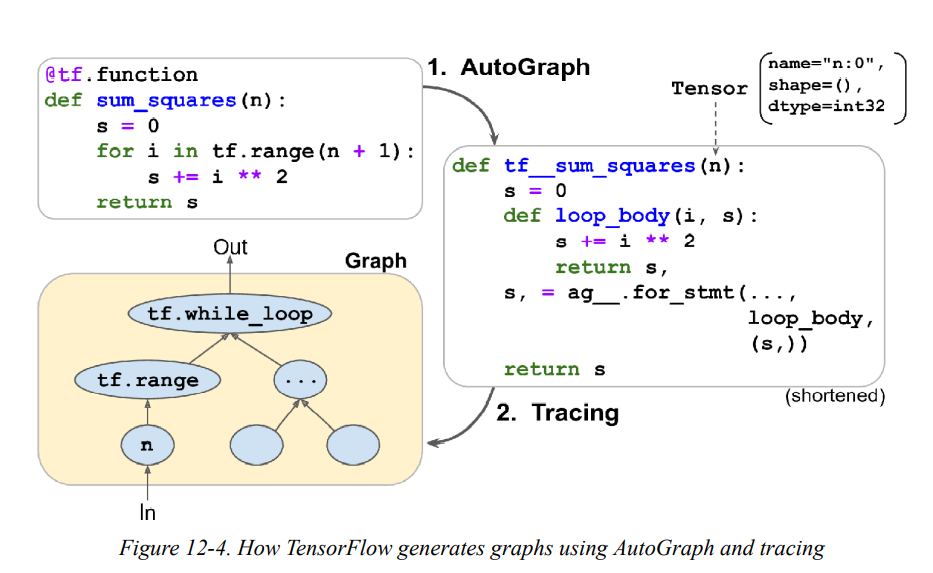

Next, TensorFlow calls this “upgraded” function, but instead of passing the
argument, it passes a symbolic tensor—a tensor without any actual value,
only a name, a data type, and a shape. For example, if you call
sum_squares(tf.constant(10)), then the tf__sum_squares() function
will be called with a symbolic tensor of type int32 and shape []. The
function will run in graph mode, meaning that each TensorFlow operation
will add a node in the graph to represent itself and its output tensor(s) (as
opposed to the regular mode, called eager execution, or eager mode). In
graph mode, TF operations do not perform any computations. This should
feel familiar if you know TensorFlow 1, as graph mode was the default
mode. In Figure 12-4, you can see the tf__sum_squares() function being
called with a symbolic tensor as its argument (in this case, an int32 tensor
of shape []) and the final graph being generated during tracing. The nodes
represent operations, and the arrows represent tensors (both the generated
function and the graph are simplified).

TIP

To view the generated function’s source code, you can call
tf.autograph.to_code(sum_squares.python_function). The code is not meant to
be pretty, but it can sometimes help for debugging.

### TF Function Rules

Most of the time, converting a Python function that performs TensorFlow
operations into a TF Function is trivial: decorate it with @tf.function or
let Keras take care of it for you. However, there are a few rules to respect:

- If you call any external library, including NumPy or even the
standard library, this call will run only during tracing; it will not be
part of the graph. Indeed, a TensorFlow graph can only include
TensorFlow constructs (tensors, operations, variables, datasets, and
so on). So, make sure you use tf.reduce_sum() instead of
np.sum(), tf.sort() instead of the built-in sorted() function,
and so on (unless you really want the code to run only during
tracing). This has a few additional implications:
 - If you define a TF Function f(x) that just returns
np.random.rand(), a random number will only be
generated when the function is traced, so
f(tf.constant(2.)) and f(tf.constant(3.)) will
return the same random number, but
f(tf.constant([2., 3.])) will return a different one.
If you replace np.random.rand() with
tf.random.uniform([]), then a new random number
will be generated upon every call, since the operation will
be part of the graph.
 - If your non-TensorFlow code has side effects (such as
logging something or updating a Python counter), then
you should not expect those side effects to occur every
time you call the TF Function, as they will only occur
when the function is traced.
 - You can wrap arbitrary Python code in a
tf.py_function() operation, but doing so will hinder
performance, as TensorFlow will not be able to do any
graph optimization on this code. It will also reduce
portability, as the graph will only run on platforms where
Python is available (and where the right libraries are
installed).
- You can call other Python functions or TF Functions, but they
should follow the same rules, as TensorFlow will capture their
operations in the computation graph. Note that these other
functions do not need to be decorated with @tf.function.
- If the function creates a TensorFlow variable (or any other stateful
TensorFlow object, such as a dataset or a queue), it must do so
upon the very first call, and only then, or else you will get an
exception. It is usually preferable to create variables outside of the
TF Function (e.g., in the build() method of a custom layer). If
you want to assign a new value to the variable, make sure you call
its assign() method, instead of using the = operator.
- The source code of your Python function should be available to
TensorFlow. If the source code is unavailable (for example, if you
define your function in the Python shell, which does not give
access to the source code, or if you deploy only the compiled *.pyc
Python files to production), then the graph generation process will
fail or have limited functionality.
- TensorFlow will only capture for loops that iterate over a tensor or
a dataset. So make sure you use for i in tf.range(x) rather
than for i in range(x), or else the loop will not be captured in
the graph. Instead, it will run during tracing. (This may be what
you want if the for loop is meant to build the graph, for example
to create each layer in a neural network.)
- As always, for performance reasons, you should prefer a vectorized
implementation whenever you can, rather than using loops.

### TF Functions and Concrete Functions

In [ ]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function.graph

In [ ]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [ ]:
concrete_function.graph

In [ ]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [ ]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [ ]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [ ]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [ ]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [ ]:
concrete_function.function_def.signature

name: "__inference_cube_1073862"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [ ]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [ ]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [ ]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # New shape: trace!


print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)


print: Tensor("x:0", shape=(3, 2), dtype=float32)


It is also possible to specify a particular input signature:

In [ ]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)
    return images[:, ::2, ::2] # drop half the rows and columns

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # Traces the function.
preprocessed_images = shrink(img_batch_2) # Reuses the same concrete function.

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [ ]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # rejects unexpected types or shapes
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None))


### Using Autograph To Capture Control Flow

A "static" `for` loop using `range()`:

In [ ]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [ ]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using `tf.while_loop()`:

In [ ]:
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [ ]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" `for` loop using `tf.range()` (captured by autograph):

In [ ]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [ ]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### Handling Variables and Other Resources in TF Functions

In [ ]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

In [ ]:
increment(counter)
increment(counter)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [ ]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [ ]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [ ]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [ ]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [ ]:
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

In [ ]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

## Using TF Functions with tf.keras (or Not)

By default, tf.keras will automatically convert your custom code into TF Functions, no need to use
`tf.function()`:

In [ ]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [ ]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [ ]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Custom model
class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
340/363 [===========================>..] - ETA: 0s - loss: 2.8762 - my_mae: 1.2771Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
363/363 [==============================] - 1s 1ms/step - loss: 2.7755 - my_mae: 1.2455 - val_loss: 0.5569 - val_my_mae: 0.4819
Epoch 2/2
162/162 [==============================] - 0s 469us/step - loss: 0.4164 - my_mae: 0.4639


[0.4163525104522705, 0.4639028012752533]

You can turn this off by creating the model with `dynamic=True` (or calling `super().__init__(dynamic=True, **kwargs)` in the model's constructor):

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = MyModel(dynamic=True)

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

Not the custom code will be called at each iteration. Let's fit, validate and evaluate with tiny datasets to avoid getting too much output:

In [ ]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.507260322570801, 2.0566811561584473]

Alternatively, you can compile a model with `run_eagerly=True`:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = MyModel()

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [ ]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.507260322570801, 2.0566811561584473]

## Custom Optimizers

Defining custom optimizers is not very common, but in case you are one of the happy few who gets to write one, here is an example:

In [ ]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 0s 444us/step - loss: 4.9648
Epoch 2/5
363/363 [==============================] - 0s 444us/step - loss: 1.7888
Epoch 3/5
363/363 [==============================] - 0s 437us/step - loss: 1.0021
Epoch 4/5
363/363 [==============================] - 0s 451us/step - loss: 0.7869
Epoch 5/5
363/363 [==============================] - 0s 446us/step - loss: 0.7122


# Summary

It’s time to sum up! In this chapter we started with a brief overview of
TensorFlow, then we looked at TensorFlow’s low-level API, including
tensors, operations, variables, and special data structures. We then used
these tools to customize almost every component in tf.keras. Finally, we
looked at how TF Functions can boost performance, how graphs are
generated using AutoGraph and tracing, and what rules to follow when you
write TF Functions (if you would like to open the black box a bit further,
for example to explore the generated graphs, you will find technical details
in Appendix G).

# Exercises

## 1. to 11.
See Appendix A.

## 12. Implement a custom layer that performs _Layer Normalization_
_We will use this type of layer in Chapter 15 when using Recurrent Neural Networks._

### a.
_Exercise: The `build()` method should define two trainable weights *α* and *β*, both of shape `input_shape[-1:]` and data type `tf.float32`. *α* should be initialized with 1s, and *β* with 0s._

Solution: see below.

### b.
_Exercise: The `call()` method should compute the mean_ μ _and standard deviation_ σ _of each instance's features. For this, you can use `tf.nn.moments(inputs, axes=-1, keepdims=True)`, which returns the mean μ and the variance σ<sup>2</sup> of all instances (compute the square root of the variance to get the standard deviation). Then the function should compute and return *α*⊗(*X* - μ)/(σ + ε) + *β*, where ⊗ represents itemwise multiplication (`*`) and ε is a smoothing term (small constant to avoid division by zero, e.g., 0.001)._

In [ ]:
class LayerNormalization(keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

Note that making _ε_ a hyperparameter (`eps`) was not compulsory. Also note that it's preferable to compute `tf.sqrt(variance + self.eps)` rather than `tf.sqrt(variance) + self.eps`. Indeed, the derivative of sqrt(z) is undefined when z=0, so training will bomb whenever the variance vector has at least one component equal to 0. Adding _ε_ within the square root guarantees that this will never happen.

### c.
_Exercise: Ensure that your custom layer produces the same (or very nearly the same) output as the `keras.layers.LayerNormalization` layer._

Let's create one instance of each class, apply them to some data (e.g., the training set), and ensure that the difference is negligeable.

In [ ]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = keras.layers.LayerNormalization()

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=5.6045884e-08>

Yep, that's close enough. To be extra sure, let's make alpha and beta completely random and compare again:

In [ ]:
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=2.2921004e-08>

Still a negligeable difference! Our custom layer works fine.

## 13. Train a model using a custom training loop to tackle the Fashion MNIST dataset
_The Fashion MNIST dataset was introduced in Chapter 10._

### a.
_Exercise: Display the epoch, iteration, mean training loss, and mean accuracy over each epoch (updated at each iteration), as well as the validation loss and accuracy at the end of each epoch._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

### b.
_Exercise: Try using a different optimizer with a different learning rate for the upper layers and the lower layers._

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax"),
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

In [ ]:
lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))                    
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]